In [1]:
import cv2
import os
import tifffile
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

In [2]:
save_folder = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/prediction/"
cat_list = ["planet_sentinel"]
model_list = ["unet-resnet50-4classes_dice-berhu-_multiclass_21-01-2023_2"]
epoch_list = ["47epoch"]

city = "shenzhen"

In [3]:
i = 0
image_path = os.path.join(save_folder,cat_list[i],model_list[i],epoch_list[i],city)
os.listdir(image_path)

['Shenzhen_2020_12_FullPath.tiff.aux.xml',
 'Shenzhen_2022_12_FullPath.tiff.aux.xml',
 'Shenzhen_2021_12_FullPath.tiff.aux.xml',
 'Shenzhen_2019_12_FullPath.tiff.aux.xml',
 'Shenzhen_2016_12_FullPath.tiff',
 'Shenzhen_2017_12_FullPath.tiff',
 'Shenzhen_2020_12_FullPath.tiff',
 'Shenzhen_2018_12_FullPath.tiff.aux.xml',
 'Shenzhen_2018_12_FullPath.tiff',
 'Shenzhen_2016_12_FullPath.tiff.aux.xml',
 'Shenzhen_2017_12_FullPath.tiff.aux.xml',
 'Shenzhen_2019_12_FullPath.tiff',
 'Shenzhen_2022_12_FullPath.tiff',
 'Shenzhen_2021_12_FullPath.tiff']

In [4]:
image = np.asarray(tifffile.imread(os.path.join(image_path,'Shenzhen_2021_12_FullPath.tiff'))).astype(np.float32)
image = np.round(image).astype(int)

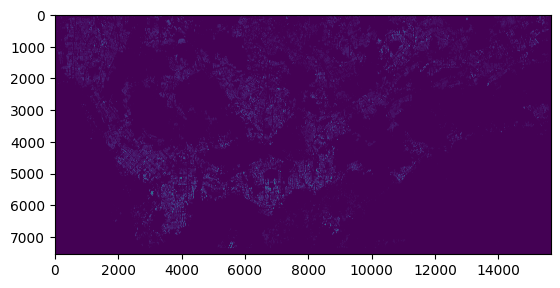

In [80]:
plt.imshow(image)

In [5]:
image_shape = image.shape
y_coords, x_coords = np.meshgrid(np.arange(image_shape[1]), np.arange(image_shape[0]))
input_immage = np.stack((image,y_coords, x_coords), axis=-1)

In [6]:
# Flatten the image to shape (num_pixels, 1)
flat_image = input_immage.reshape((-1, 3))

In [7]:
input_flat_image  = flat_image[flat_image[:,0]>0]
input_flat_image.shape

(12588362, 3)

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate bandwidth
#bandwidth = estimate_bandwidth(input_flat_image, quantile=0.2, n_samples=500)

# Perform Mean Shift clustering
ms = MeanShift(bandwidth=500, bin_seeding=True)
ms.fit(input_flat_image)


MeanShift(bandwidth=500, bin_seeding=True)

In [13]:
ms.labels_

array([ 2,  2,  2, ..., 48, 48, 48])

In [14]:
ms.labels_.max()

60

## with the return of centroid value and coordinate for each point

In [85]:
# Assign the cluster center to each pixel
clustered = ms.cluster_centers_[ms.labels_]

In [86]:
clustered

array([[  14.11752951, 6925.09700468, 2687.43646266],
       [  14.11752951, 6925.09700468, 2687.43646266],
       [  14.11752951, 6925.09700468, 2687.43646266],
       ...,
       [  14.11752951, 6925.09700468, 2687.43646266],
       [  14.11752951, 6925.09700468, 2687.43646266],
       [  14.11752951, 6925.09700468, 2687.43646266]])

In [87]:
output_flat_image = image.copy().reshape((-1, 1))
output_flat_image[output_flat_image>0] = clustered[:,0]

clustered_image = output_flat_image.reshape(image.shape)

In [88]:
#vlaue of 
clustered_image.max()

14

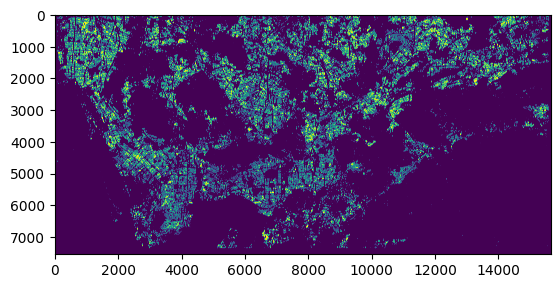

In [89]:
plt.imshow(clustered_image)

## return the id of each centroid

In [15]:
ms.labels_.max()

60

In [16]:
label_flat_image = image.copy().reshape((-1, 1))
label_flat_image[label_flat_image>0] = (ms.labels_+1)/(ms.labels_.max()+1)*255

label_image = label_flat_image.reshape(image.shape).astype(np.uint8)

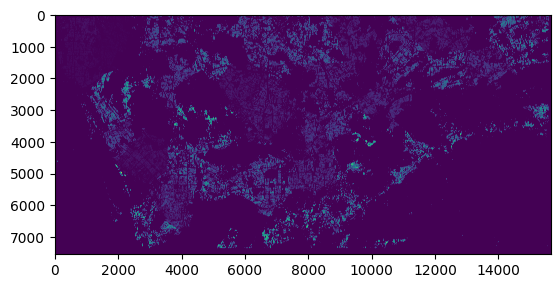

In [17]:
plt.imshow(label_image)

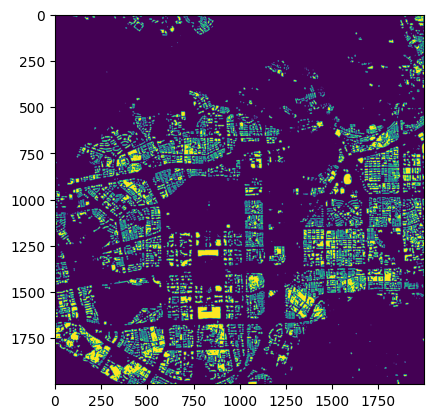

In [93]:
plt.imshow(label_image[4000:6000,6000:8000])

# exmaple code

In [22]:
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

In [23]:
X

array([[-0.74416751, -0.46340497],
       [-0.48781225,  0.3678308 ],
       [ 0.70261681, -1.18483692],
       ...,
       [-1.73218967, -0.7534157 ],
       [-0.61712739, -0.68283265],
       [-1.40405173, -0.56480162]])

In [7]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


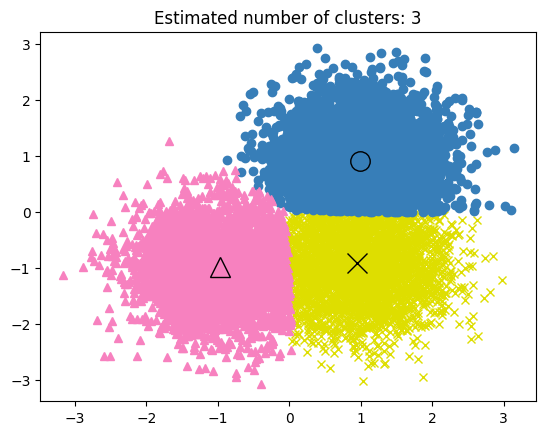

In [8]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()